In [1]:
import wandb
from collections import defaultdict
import pandas as pd
import numpy as np

import random

import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import HTML
from IPython.display import display_html

%load_ext autoreload
%autoreload 2

In [2]:
COLORS = {}
COLORS["MSCN"] = "#4260f5"
COLORS["MSCN (Ours)"] = "Green"

In [3]:
api = wandb.Api()

In [4]:
# runs = api.runs("pari/skdwda-pari",
#     {"$or": [
#        {"config.algs": "dqo"},
#        #{"config.wandb_tags":"run_all,final1"},
#        #{"config.wandb_tags":"run_all,final2"},
#        {"config.wandb_tags":"run_all,final2-fixedBestVal"}
#     ]
#     })

runs = api.runs("pari/MyCEB",
    {"$and": [
       {"config.algs": "mscn"},
       {"config.train_test_split_kind":"custom"},
       #{"tags":"v17"},
       {"tags":"new-custom-runs"},
       {"config.max_discrete_featurizing_buckets":10},
       {"config.query_dir":"queries/imdb"}
    ]
    })
print(f"Found {len(runs)} runs")

Found 10 runs


In [5]:
# TRAIN_TMPS="2b"
# SEP=1
# BINS=30
# EMB_FN="none"
# DECAY=0

KEYNAMES = ["train_tmps", "test_tmps", "max_discrete_featurizing_buckets", "embedding_fn", 
            "weight_decay", "feat_onlyseen_preds", "loss_func_name", "feat_separate_alias"]
#VALS = ["1a", "2a,2b", 10, "none", 0, 1, "mse", 0]
VALS = ["2b", "2a", 10, "none", 0, 1, "mse", 0]

if VALS[0] == "2b":
    PG_BASELINE_VAL = 8.849
    PG_BASELINE_COST = 7.599
elif VALS[0] == "1a":
    PG_BASELINE_VAL = 4.433
    PG_BASELINE_COST = 8.004
else:
    assert False
    
SAVE_DIR = "Users/pari/Desktop/"

In [6]:
import time
start = time.time()
summary_list, config_list, name_list = [], [], []
#TAGS = ["baselines", "baseline", "best_model_0.2", "best_model"]
dfs = []

for run in runs:
    skip = False
#    for ci, curkey in enumerate(KEYNAMES):
#         if not curkey in run.config:
#             skip = True
#             break
#         if not run.config[curkey] == VALS[ci]:
#             skip = True
#             break

    if skip:
        continue
    if run.State != "finished":
        continue
    
    data = defaultdict(list)
    data["Tags"].append(run.Tags)
    data["name"].append(run.name)
    
    
    for k,v in run.config.items():
        if not k.startswith("_") or not k.contains("/"):
            data[k].append(v)

    for k,v in run.summary._json_dict.items():
        if k.startswith("_"):
            continue
        if "/" in k:
            continue
        data[k].append(v)
        
    dfs.append(pd.DataFrame(data))

print("took: ", time.time()-start)

took:  0.057676076889038086


In [22]:
runs[0]

<Run pari/MyCEB/3ea2i57e (finished)>

In [7]:
df = pd.concat(dfs)

In [8]:
print(len(df))
df.head(5)

10


,Tags,name,lr,pwd,algs,port,seed,user,opt_lr,skip7a,...,Final-PostgresPlanCost-C-test-mean,Final-PostgresPlanCost-C-train-mean,Final-Relative-PG-TotalPPCost-train,Final-QError-test-99p,Final-Relative-TotalPPCost-val,Final-PPError-test-99p,Final-PPError-val-mean,Final-Relative-PG-TotalPPCost-val,epoch,Final-PPError-val-99p
0,"[new-custom-runs, v17b]",lemon-pond-10633,0.0001,password,mscn,5431,123,ceb,0.005,0,...,4.837055e+07,1525300.708,-1,798.649,2.805,2.305759e+08,9.400653e+05,-1,29,1.255016e+07
0,"[new-custom-runs, v17b]",vivid-forest-10632,0.0001,password,mscn,5431,123,ceb,0.005,0,...,1.636747e+06,1266693.662,-1,421.896,2.609,5.253858e+06,8.379721e+05,-1,29,6.907809e+06
0,"[new-custom-runs, v17b]",swept-water-10631,0.0001,password,mscn,5431,123,ceb,0.005,0,...,2.029049e+06,1516419.308,-1,171.936,3.001,1.201602e+07,1.042401e+06,-1,29,1.255016e+07
0,"[new-custom-runs, v17b]",cosmic-glitter-10630,0.0001,password,mscn,5431,123,ceb,0.005,0,...,3.224484e+06,1522628.099,-1,239.875,3.553,1.495118e+07,1.330061e+06,-1,29,9.042448e+06
0,"[new-custom-runs, v17b]",clean-pond-10629,0.0001,password,mscn,5431,123,ceb,0.005,0,...,2.539397e+06,1439226.800,-1,173.599,2.880,1.651594e+07,9.793372e+05,-1,29,1.107407e+07


In [9]:
def get_row_featurization(row):
    if row["table_features"] == 1 \
        and row["set_column_feature"] in ["1", 1, "onehot"] \
        and row["join_features"] in ["1", 1, "onehot"] \
        and row["onehot_dropout"] == 0:
        return "MSCN"
    elif row["onehot_dropout"] == 2:
        return "MSCN (Ours)" 
    else:
        return "unknown"

In [10]:
print(len(set(df["name"])))
print(len(df))
print(df.keys())

10
10
Index(['Tags', 'name', 'lr', 'pwd', 'algs', 'port', 'seed', 'user', 'opt_lr',
       'skip7a',
       ...
       'Final-PostgresPlanCost-C-test-mean',
       'Final-PostgresPlanCost-C-train-mean',
       'Final-Relative-PG-TotalPPCost-train', 'Final-QError-test-99p',
       'Final-Relative-TotalPPCost-val', 'Final-PPError-test-99p',
       'Final-PPError-val-mean', 'Final-Relative-PG-TotalPPCost-val', 'epoch',
       'Final-PPError-val-99p'],
      dtype='object', length=117)


In [11]:
df["Featurization"] = df.apply(lambda x: get_row_featurization(x), axis=1)

In [12]:
df.groupby(["Featurization"]).count()

,Tags,name,lr,pwd,algs,port,seed,user,opt_lr,skip7a,...,Final-PostgresPlanCost-C-test-mean,Final-PostgresPlanCost-C-train-mean,Final-Relative-PG-TotalPPCost-train,Final-QError-test-99p,Final-Relative-TotalPPCost-val,Final-PPError-test-99p,Final-PPError-val-mean,Final-Relative-PG-TotalPPCost-val,epoch,Final-PPError-val-99p
Featurization,,,,,,,,,,,,,,,,,,,,,
MSCN,5,5,5,5,5,5,5,5,5,5,...,5,5,5,5,5,5,5,5,5,5
MSCN (Ours),5,5,5,5,5,5,5,5,5,5,...,5,5,5,5,5,5,5,5,5,5


In [13]:
# print(set(df["set_column_feature"]))
# print(set(df["join_features"]))
pdf = df[df.Featurization != "unknown"]
pdf = pdf[~pdf["Final-Relative-TotalPPCost-test"].isna()]

In [14]:
pdf.head(5)

,Tags,name,lr,pwd,algs,port,seed,user,opt_lr,skip7a,...,Final-PostgresPlanCost-C-train-mean,Final-Relative-PG-TotalPPCost-train,Final-QError-test-99p,Final-Relative-TotalPPCost-val,Final-PPError-test-99p,Final-PPError-val-mean,Final-Relative-PG-TotalPPCost-val,epoch,Final-PPError-val-99p,Featurization
0,"[new-custom-runs, v17b]",lemon-pond-10633,0.0001,password,mscn,5431,123,ceb,0.005,0,...,1525300.708,-1,798.649,2.805,2.305759e+08,9.400653e+05,-1,29,1.255016e+07,MSCN
0,"[new-custom-runs, v17b]",vivid-forest-10632,0.0001,password,mscn,5431,123,ceb,0.005,0,...,1266693.662,-1,421.896,2.609,5.253858e+06,8.379721e+05,-1,29,6.907809e+06,MSCN (Ours)
0,"[new-custom-runs, v17b]",swept-water-10631,0.0001,password,mscn,5431,123,ceb,0.005,0,...,1516419.308,-1,171.936,3.001,1.201602e+07,1.042401e+06,-1,29,1.255016e+07,MSCN
0,"[new-custom-runs, v17b]",cosmic-glitter-10630,0.0001,password,mscn,5431,123,ceb,0.005,0,...,1522628.099,-1,239.875,3.553,1.495118e+07,1.330061e+06,-1,29,9.042448e+06,MSCN (Ours)
0,"[new-custom-runs, v17b]",clean-pond-10629,0.0001,password,mscn,5431,123,ceb,0.005,0,...,1439226.800,-1,173.599,2.880,1.651594e+07,9.793372e+05,-1,29,1.107407e+07,MSCN


./2b-PPC.pdf


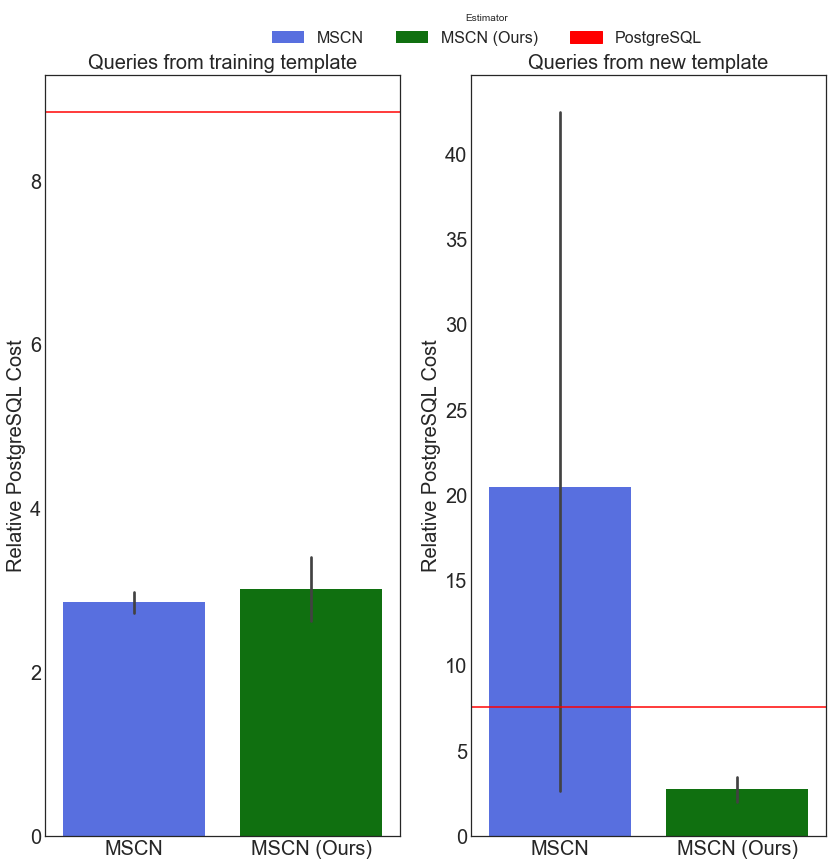

In [15]:
import matplotlib.patches as mpatches

plt.style.use("seaborn-white")
fig, axs = plt.subplots(figsize=(14,14), nrows=1, ncols=2)
ymin = 0
ymax = np.max([np.max(pdf["Final-Relative-TotalPPCost-val"].values), 
              np.max(pdf["Final-Relative-TotalPPCost-test"].values)])

#print(ymin, ymax)

ax = axs[0]
sns.barplot(data=pdf, hue="Featurization", y="Final-Relative-TotalPPCost-val", 
                x="Featurization", dodge=False, ax=ax,
            palette=COLORS)
ax.legend(title="", loc="center left", bbox_to_anchor=(0.60, 1.10), ncol=2, frameon=False, 
                fontsize=20)
ax.set_ylabel("Relative PostgreSQL Cost", fontsize=20)
ax.set_title("Queries from training template", fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=20)

ax.set_xlabel("")
ax.axhline(y=PG_BASELINE_VAL, color="red")
#ax.set_ylim([ymin, ymax])

ax.legend().remove()

legend = ax.legend(loc='upper left', bbox_to_anchor=(0.6,1.1), ncol=3,
                  prop={'size': 16})
handles, labels = ax.get_legend_handles_labels()
red_patch = mpatches.Patch(color='red', label='PostgreSQL')
handles.append(red_patch)
labels.append("PostgreSQL")
legend._legend_box = None
legend._init_legend_box(handles, labels)
legend._set_loc(legend._loc)
legend.set_title("Estimator")

#ax.set_ylim([ymin,ymax])

ax = axs[1]
sns.barplot(data=pdf, hue="Featurization", y="Final-Relative-TotalPPCost-test", 
                x="Featurization", dodge=False, ax=ax, 
            palette=COLORS)
ax.set_title("Queries from new template", fontsize=20)
ax.legend().remove()
ax.set_ylabel("")
ax.tick_params(axis='both', which='major', labelsize=20)
ax.set_ylabel("Relative PostgreSQL Cost", fontsize=20)
ax.set_xlabel("")
ax.axhline(y=PG_BASELINE_COST, color="red")

#ax.set_ylim([ymin,ymax])

#FN = SAVE_DIR + "/" + VALS[0] + ".png"
FN = "./" + VALS[0] + "-PPC.pdf"
print(FN)

plt.savefig(FN)

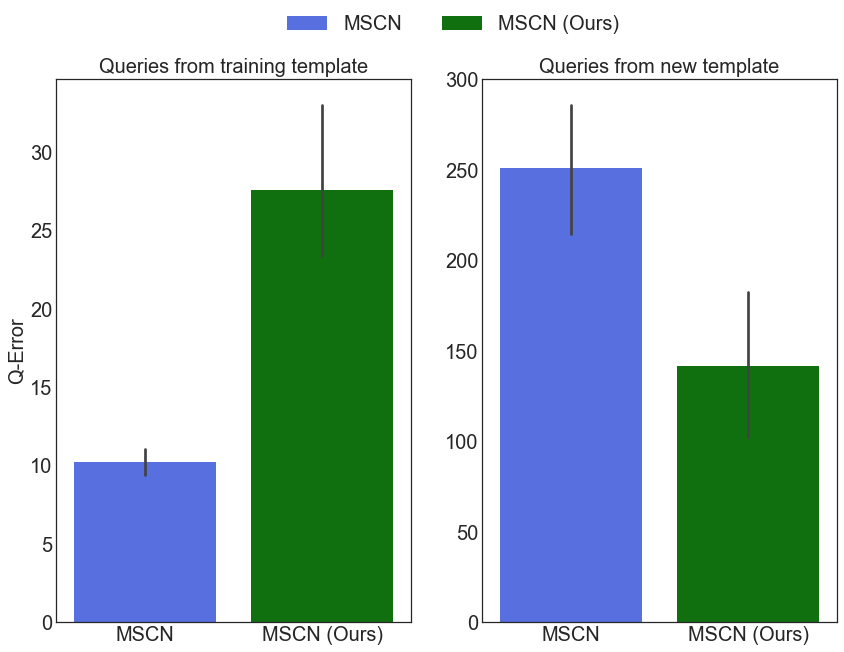

In [16]:
plt.style.use("seaborn-white")
fig, axs = plt.subplots(figsize=(14,10), nrows=1, ncols=2)
# ymin = 0
# ymax = np.max([np.max(pdf["Final-QError-val-mean"].values), 
#               np.max(pdf["Final-QError-test-mean"].values)])

ax = axs[0]
sns.barplot(data=pdf, hue="Featurization", y="Final-QError-val-mean", 
                x="Featurization", dodge=False, ax=ax,
           palette=COLORS)
ax.legend(title="", loc="center left", bbox_to_anchor=(0.60, 1.10), ncol=2, frameon=False, 
                fontsize=20)
ax.set_ylabel("Q-Error", fontsize=20)
ax.set_title("Queries from training template", fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=20)
ax.set_xlabel("")
#ax.axhline(y=PG_BASELINE_VAL, color="red")
#ax.set_ylim([ymin,ymax])

ax = axs[1]
sns.barplot(data=pdf, hue="Featurization", y="Final-QError-test-mean", 
                x="Featurization", dodge=False, ax=ax,
           palette=COLORS)
ax.set_title("Queries from new template", fontsize=20)
ax.legend().remove()
ax.set_ylabel("")
ax.tick_params(axis='both', which='major', labelsize=20)
#ax.set_ylabel("Relative PostgreSQL Cost", fontsize=20)
ax.set_xlabel("")
#ax.axhline(y=PG_BASELINE_COST, color="red")
#ax.set_ylim([ymin,ymax])

#FN = SAVE_DIR + "/" + VALS[0] + ".png"
FN = "./" + VALS[0] + "Q-Error.pdf"
plt.savefig(FN)

In [17]:
# sns.barplot(data=pdf, hue="Featurization", y="Final-Relative-TotalPPCost-val", 
#                 x="Featurization", dodge=False)

In [18]:
pdf.keys()

Index(['Tags', 'name', 'lr', 'pwd', 'algs', 'port', 'seed', 'user', 'opt_lr',
       'skip7a',
       ...
       'Final-PostgresPlanCost-C-train-mean',
       'Final-Relative-PG-TotalPPCost-train', 'Final-QError-test-99p',
       'Final-Relative-TotalPPCost-val', 'Final-PPError-test-99p',
       'Final-PPError-val-mean', 'Final-Relative-PG-TotalPPCost-val', 'epoch',
       'Final-PPError-val-99p', 'Featurization'],
      dtype='object', length=118)

<AxesSubplot:xlabel='Featurization', ylabel='Final-QError-test-mean'>

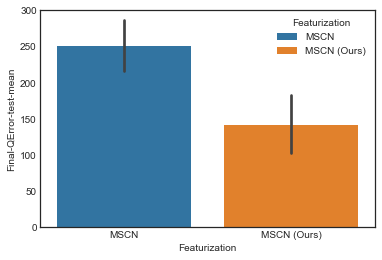

In [19]:
sns.barplot(data=pdf, hue="Featurization", y="Final-QError-test-mean", 
                x="Featurization", dodge=False)

<AxesSubplot:xlabel='name', ylabel='Final-Relative-TotalPPCost-test'>

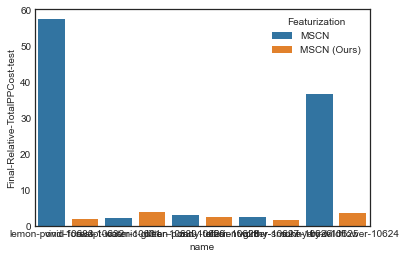

In [20]:
sns.barplot(data=pdf, hue="Featurization", y="Final-Relative-TotalPPCost-test", 
                x="name", dodge=False)

In [21]:
print(set(df["feat_onlyseen_preds"]))
print(set(df["feat_separate_alias"]))

{1}
{1}
